In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np 
import time
import random
import os
import json
from models.rnnpb import RNNPB
from models.rnnpbnmt import RNNPBNMT
from misc.dataset import Dataset
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D

/home/daniel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
working_dir = "saves/autoenc/rnnpb20000"

In [3]:
data = Dataset("data/autoenc/easy20000/train.en", "data/autoenc/easy20000/train.en", 1, 
               vocab = os.path.join(working_dir, "vocab"))

In [4]:
with open(os.path.join(working_dir, "model.json"), "r") as f:
    model_json = json.loads(f.read())

model_name = model_json["model_name"]
reverse_source = model_json["reverse_source"]
model_params = model_json["model_params"]

model = RNNPBNMT(vocab1_size = data.first.vocab_size, vocab2_size = data.second.vocab_size, working_dir=working_dir, **model_params)

In [5]:
checkpoint = model.get_checkp()
checkpoint = tf.train.Checkpoint(**checkpoint)
newest = tf.train.latest_checkpoint(os.path.join(working_dir, "checkpoints"))
assert newest is not None
checkpoint.restore(newest)

In [6]:
def sentence_to_tensor(s, w2idx):
    s = [w2idx.get(w, w2idx["<UNK>"]) for w in s.split(" ")]
    x = tf.convert_to_tensor(s)
    return x

def tensor_to_sentence(x, idx2w):
    return " ".join(idx2w[i] for i in x)

def translate(A, B, x, B_idx2w, eps=0.0001, return_pb = False):
    x = tf.expand_dims(x, 0)
    
    pb = A.recognize(x, eps = eps)[0]
    y = B.generate(pb, max_length = round(1.5 * len(x[0])), start=START, end=END)
    
    s = tensor_to_sentence(y, B_idx2w)
    return (s, pb[0]) if return_pb else s


In [14]:
colors = ['red', 'blue', 'green', 'black', 'orange', 'purple', 'pink', 'gray' ,'cyan', 'magenta']
def plot_pbs(A_pbs, B_pbs, plot_zero = False):

    pb_dim = A_pbs.shape[1]

    pca = PCA(n_components = 2)
    pca.fit(np.concatenate([A_pbs, B_pbs]))

    A_pbs, B_pbs = pca.transform(A_pbs), pca.transform(B_pbs)

    unis = np.random.uniform(size=A_pbs.shape[0])

    for i in range(A_pbs.shape[0]):

        color = colors[i]

        for p, m in zip([A_pbs[i], B_pbs[i]], ['s', 'o']):
            x, y = p

            plt.scatter(x, y, c = color, marker=m)

        legend_elements = [Line2D([0], [0], marker='o', color='w', label='Recognized', markerfacecolor='white', markeredgecolor='black', markersize=7),
                           Line2D([0], [0], marker='s', color='w', label='Trained', markerfacecolor='white', markeredgecolor='black', markersize=7)]
        plt.legend(handles=legend_elements)

    if plot_zero:
        z = pca.transform(np.zeros((1, pb_dim)))
        x, y = z[0]
        plt.scatter(x, y, c='black', marker='+')
    
    plt.xlabel("First component")
    plt.ylabel("Second component")
    plt.savefig("plot.png", dpi=1000, bbox_inches = 'tight', pad_inches = 0.1)
    plt.show()

In [8]:
def calculate_perplexity(x, x_length, pb):
    x_inp = x[:, :-1]
    x_tar = x[:, 1:]
    
    logits, _, _ = model.A(x_inp, pbs=pb)
    
    _, perplexity = model.loss(logits=logits, targets=x_tar, target_lengths = x_length - 1)
    
    return perplexity
    

In [9]:
examples = [row for _, row in zip(range(10), data)]

train_pbs = []
rec_pbs = []
train_perplexities, rec_perplexities = [], []
for X, X_length, Y, Y_length, ids in examples:
    _, _, train_pb = model.A(X, ids)
    train_pbs.append(train_pb[0])
    
    rec_pb = model.A.recognize(X)
    rec_pbs.append(rec_pb[0])
    
    train_perplexities.append(calculate_perplexity(X, X_length, train_pb))
    rec_perplexities.append(calculate_perplexity(X, X_length, rec_pb))

W0703 16:59:27.362489 140430838925120 deprecation.py:323] From /home/daniel/venv/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:3868: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Recognition iteration 0 Loss 72.372
Recognition iteration 100 Loss 0.443
Recognition iteration 200 Loss 0.066
Recognition iteration 300 Loss 0.033
Recognition iteration 400 Loss 0.022
Recognition finished, iteration 485 Loss 0.018
Recognition iteration 0 Loss 81.764
Recognition iteration 100 Loss 0.035
Recognition iteration 200 Loss 0.006
Recognition finished, iteration 216 Loss 0.006
Recognition iteration 0 Loss 73.415
Recognition iteration 100 Loss 4.876
Recognition iteration 200 Loss 0.016
Recognition finished, iteration 293 Loss 0.006
Recognition iteration 0 Loss 69.547
Recognition iteration 100 Loss 0.145
Recognition iteration 200 Loss 0.032
Recognition iteration 300 Loss 0.019
Recognition iteration 400 Loss 0.010
Recognition finished, iteration 427 Loss 0.009
Recognition iteration 0 Loss 53.837
Recognition iteration 100 Loss 0.095
Recognition iteration 200 Loss 0.030
Recognition iteration 300 Loss 0.020
Recognition iteration 400 Loss 0.015
Recognition finished, iteration 405 Loss

In [10]:
A = np.array(train_pbs)
B = np.array(rec_pbs)

print("Train perp", float(tf.reduce_mean(train_perplexities)))
print("Recog perp", float(tf.reduce_mean(rec_perplexities)))

Train perp 1.0234054327011108
Recog perp 1.0012212991714478


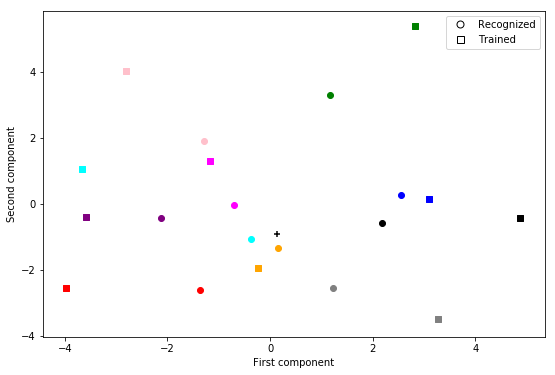

In [15]:
plt.figure(num=1, figsize=(9, 6))
plot_pbs(A, B, plot_zero=True)

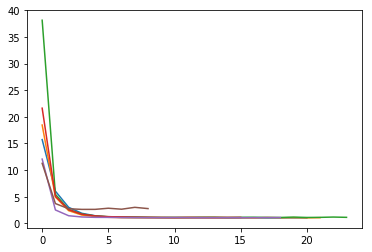

In [12]:
rnnpbs = ["saves/autoenc/rnnpb20000", "saves/autoenc/rnnpb50000", "saves/autoenc/rnnpbfull"]
encdecs = ["saves/autoenc/encdec20000", "saves/autoenc/encdec50000", "saves/autoenc/encdecfull"]

for models, line in zip([rnnpbs, encdecs], ['-', '--']):
    for i, model in enumerate(models):
        with open(os.path.join(model, "training_stats.json"), 'r') as f:
            stats = json.loads(f.read())
        
        dev_perps = stats['dev_perplexities']
        
        plt.plot(dev_perps)

plt.show()

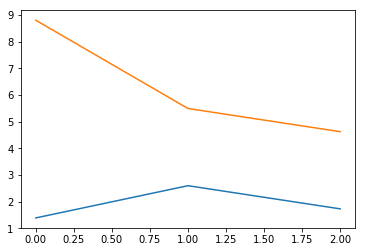

In [13]:
encdec_time_per_batch = []
rnnpb_time_per_batch = []
for models, time_per_batch in zip([rnnpbs, encdecs], [rnnpb_time_per_batch, encdec_time_per_batch]):
    for i, model in enumerate(models):
        with open(os.path.join(model, "training_stats.json"), 'r') as f:
            stats = json.loads(f.read())
        
        training_time = stats['training_time']
        
        num_batches = len(stats['batch_losses'])
        
        time_per_batch.append(training_time / num_batches)

plt.figure()
plt.plot(encdec_time_per_batch)
plt.plot(rnnpb_time_per_batch)

plt.show()